# Figure 4: Beta Factors and Cross Section
This notebook produces figure 4 of Tankersley et al. 2022. The figure displays beta crustal stretching factors (initial crustal thickness/final crustal thickness) with sediments removed from crustal thickness. It also shows a cross-section across the Siple Coast

In [1]:
# import necessary python packages
import pygmt
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from pyproj import Transformer

In [2]:
# all file paths assume this notebook is in /RIS_basement_sediment/figures
pwd = os.getcwd()
pwd

'C:\\Users\\mtankersley\\Documents\\Python_Scripts\\RIS_basement_sediment\\Figures'

## Prep data

### Gravity
from ROSETTA-Ice

In [3]:
# this was download from ROSETTA as "rs_2019_grav.csv", unecessary cols were removed, and ot was compressed
grav=pd.read_csv('../data/input/rosetta_grav.csv', header=0, index_col=None, compression='gzip')

# put line numbers into float format (L200 -> 200)
if type(grav.Line[0]) == str:
    grav.Line = grav.Line.str[1:]
grav['Line'] = pd.to_numeric(grav['Line']) 

# block median the data at 5km
rosetta_grav=pygmt.blockmedian(data=grav, 
                 spacing="5000+e", 
                 Es=True, # save Line value
                 region=[-760000,600000,-2200000,-350000])

# grid the data at 5km
pygmt.surface(x = rosetta_grav.x,
              y = rosetta_grav.y,
              z = rosetta_grav.FAG_levelled,
              spacing = '5000+e',
              region = '-660000/470000/-1400000/-400000',
              M = '4c', # region further than 2 cell (10km) away from points masked
              outgrid = '../data/results/rosetta_grav.nc')

### Local Moho model
from Shen et al. 2018

In [44]:
# Moho depth relative to the surface of the solid earth, bottom of ice/ocean.
Moho_Shen = pd.read_csv('../data/input/moho.final.dat', header=None, sep='\ ', engine='python') 
Moho_Shen.columns =['Lon','Lat','z'] 
# turn into elevation in meters
Moho_Shen.z=Moho_Shen.z.apply(lambda x:x*-1000) 
# transform to EPSG3031
transformer = Transformer.from_crs("epsg:4326", "epsg:3031") 
Moho_Shen['x'], Moho_Shen['y'] = transformer.transform(Moho_Shen['Lat'].tolist(), Moho_Shen['Lon'].tolist()) 
Moho_Shen

# grid the data at 5km
pygmt.surface(x = Moho_Shen.x,
              y = Moho_Shen.y,
              z = Moho_Shen.z,
              spacing = '10000+e',
              region = '-660000/470000/-1400000/-400000',
              M = '1c',
              outgrid = '../data/results/Shen_moho.nc')

surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.


### Colorbar histograms

In [15]:
# create East vs West Antarctic subsets for Ross Ice Shelf area, used for colorbar histograms
!gmt grdmask ..\data\shapefiles\RIS_outline.shp -G..\data/tmp\RIS_mask.nc -I5000+e -R-3330000/1900000/-3330000/1850000 -rp -NNaN/1/1
!gmt grdmask ..\data\shapefiles\WANT_RIS.shp -G..\data/tmp\WANT_mask.nc -I5000+e -R-3330000/1900000/-3330000/1850000 -rp -NNaN/1/1
!gmt grdmask ..\data\shapefiles\WANT_RIS.shp -G..\data/tmp\EANT_mask.nc -I5000+e -R-3330000/1900000/-3330000/1850000 -rp -N1/NaN/NaN

!gmt grdmath -Df ..\data/main_results/Ross_Embayment_beta.nc ..\data/tmp\RIS_mask.nc MUL = ..\data/tmp\Ross_Embayment_beta_RIS_mask.nc
!gmt grdmath -Df ..\data/tmp\Ross_Embayment_beta_RIS_mask.nc ..\data/tmp\WANT_mask.nc MUL = ..\data/tmp\Ross_Embayment_beta_RIS_WANT_mask.nc
!gmt grdmath -Df ..\data/tmp\Ross_Embayment_beta_RIS_mask.nc ..\data/tmp\EANT_mask.nc MUL = ..\data/tmp\Ross_Embayment_beta_RIS_EANT_mask.nc

### Sample data from grids

In [4]:
# see https://github.com/mdtanker/antarctic_cross_sections for a 
# notebook to create your own cross-sections for anywhere in Antarctica

# define starting and ending points of cross-section (in meters EPSG3031)
a=(-590000,-1070000)
b=(-100000,-545000)

# chose grids to sample as layers for the cross-section, top down
earth_profilelist=(
    '../data/results/BedMachine_surface_5k_wgs.nc',
    '../data/results/BedMachine_icebase_5k_wgs.nc',
    '../data/results/BedMachine_bed_5k_wgs.nc',
    '../data/main_results/Ross_Embayment_basement_filt.nc', # our basement model
    '../data/results/Shen_moho.nc') # Shen et al. 2018, The Crust and Upper Mantle Structure ...
data_profilelist=('../data/results/rosetta_grav.nc',)

# ice velocities from MEaSUREs turned in velocity magnitude by Venturelli et al. 2020. 
# subset here to a smaller region 
ice_vel='../data/input/RIS_ice_vel.nc'

GHF='../data/input/Mean.tif'# Burton-Johnson et al. 2020, Geothermal heat flow in Antarctica; The Cryosphere

# Create profile coords, and sample value from gris in "earth_profilelist" as well as GHF and Ice Velocity
def create_profile(a, b):
    df = pd.DataFrame(data=np.linspace(start=a, stop=b, num=1000), columns=["x", "y"])
    return df
points = create_profile(a, b)
points['Distance'] = np.sqrt( (points.x-points.x.min())**2 + (points.y-points.y.min())**2 )
def sample_line(points, grid):
    points[grid] = (pygmt.grdtrack(points=points, grid=grid, newcolname=str(grid), verbose='e'))[grid]
    return points
# sample Earth Profiles
for i in earth_profilelist:
    earth_profiles=sample_line(points, i)
earth_profiles = sample_line(points, ice_vel)
earth_profiles = sample_line(points, GHF)
for y in list(range(len(earth_profilelist)))[1:]:  #fill NaN's in lower layer with upper layer
    earth_profiles[earth_profilelist[y]] = np.where(earth_profiles[earth_profilelist[y]].isnull(), earth_profiles[earth_profilelist[y-1]], earth_profiles[earth_profilelist[y]]) 
# sample Data Profiles
points = create_profile(a, b)
points['Distance'] = np.sqrt( (points.x-points.x.min())**2 + (points.y-points.y.min())**2 )
for i in data_profilelist:
    data_profiles=sample_line(points, i)

earth_profiles[ice_vel].interpolate(method='linear', axis=0, inplace=True)

earth_profiles.set_index('Distance',inplace=True, drop=False)

Xresampled = np.arange(0,earth_profiles.Distance.max(),1000)

earth_profiles = earth_profiles.reindex(earth_profiles.index.union(Xresampled)).interpolate('values').loc[Xresampled]

## Color scales

In [5]:
# beta factor colorscale
beta_cpt_limits='1.4/2.3'
pygmt.makecpt(series = f'{beta_cpt_limits}/.1', cmap = 'haxby', background='o', output='../data/plotting/beta.cpt')

# GHF colorscale
pygmt.makecpt(cmap = 'jet', series = '65/77/0.5', output='../data/plotting/GHF.cpt', continuous=True, background=True)

# Ice velocity colorscale
pygmt.makecpt(cmap = 'cool', series = '0/250/1', output = '../data/plotting/vel.cpt', continuous=True)

## Figure parameters

In [6]:
# set our PyGMT figure parameters, 
# we will use an Antarctic Polar Stereographic projection (EPSG3031)
# set the region of our figure, in meters from the South Pole
e= -760_000
n= -1_500_000
w= 450_000
s= -350_000

#set figure height, width and map scale
fig_height = 150 # in mm
fig_width = fig_height*(w-e)/(s-n)
fig_ratio = (s-n)/(fig_height/1000)

# Make a GMT region string and projection strings in both ESPG3031 and Lat/Lon
fig_reg = f'{e}/{w}/{n}/{s}'
fig_proj = f"x1:{fig_ratio}"
fig_proj_ll = f"s0/-90/-71/1:{fig_ratio}"

## Make figure

C:\Users\mtankersley\miniforge3\envs\basement\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\mtankersley\miniforge3\envs\basement\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\mtankersley\miniforge3\envs\basement\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
gmtset [WARNING]: Representation of font type not recognized. Using default.
C:\Users\mtankersley\miniforge3\envs\basement\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and wi

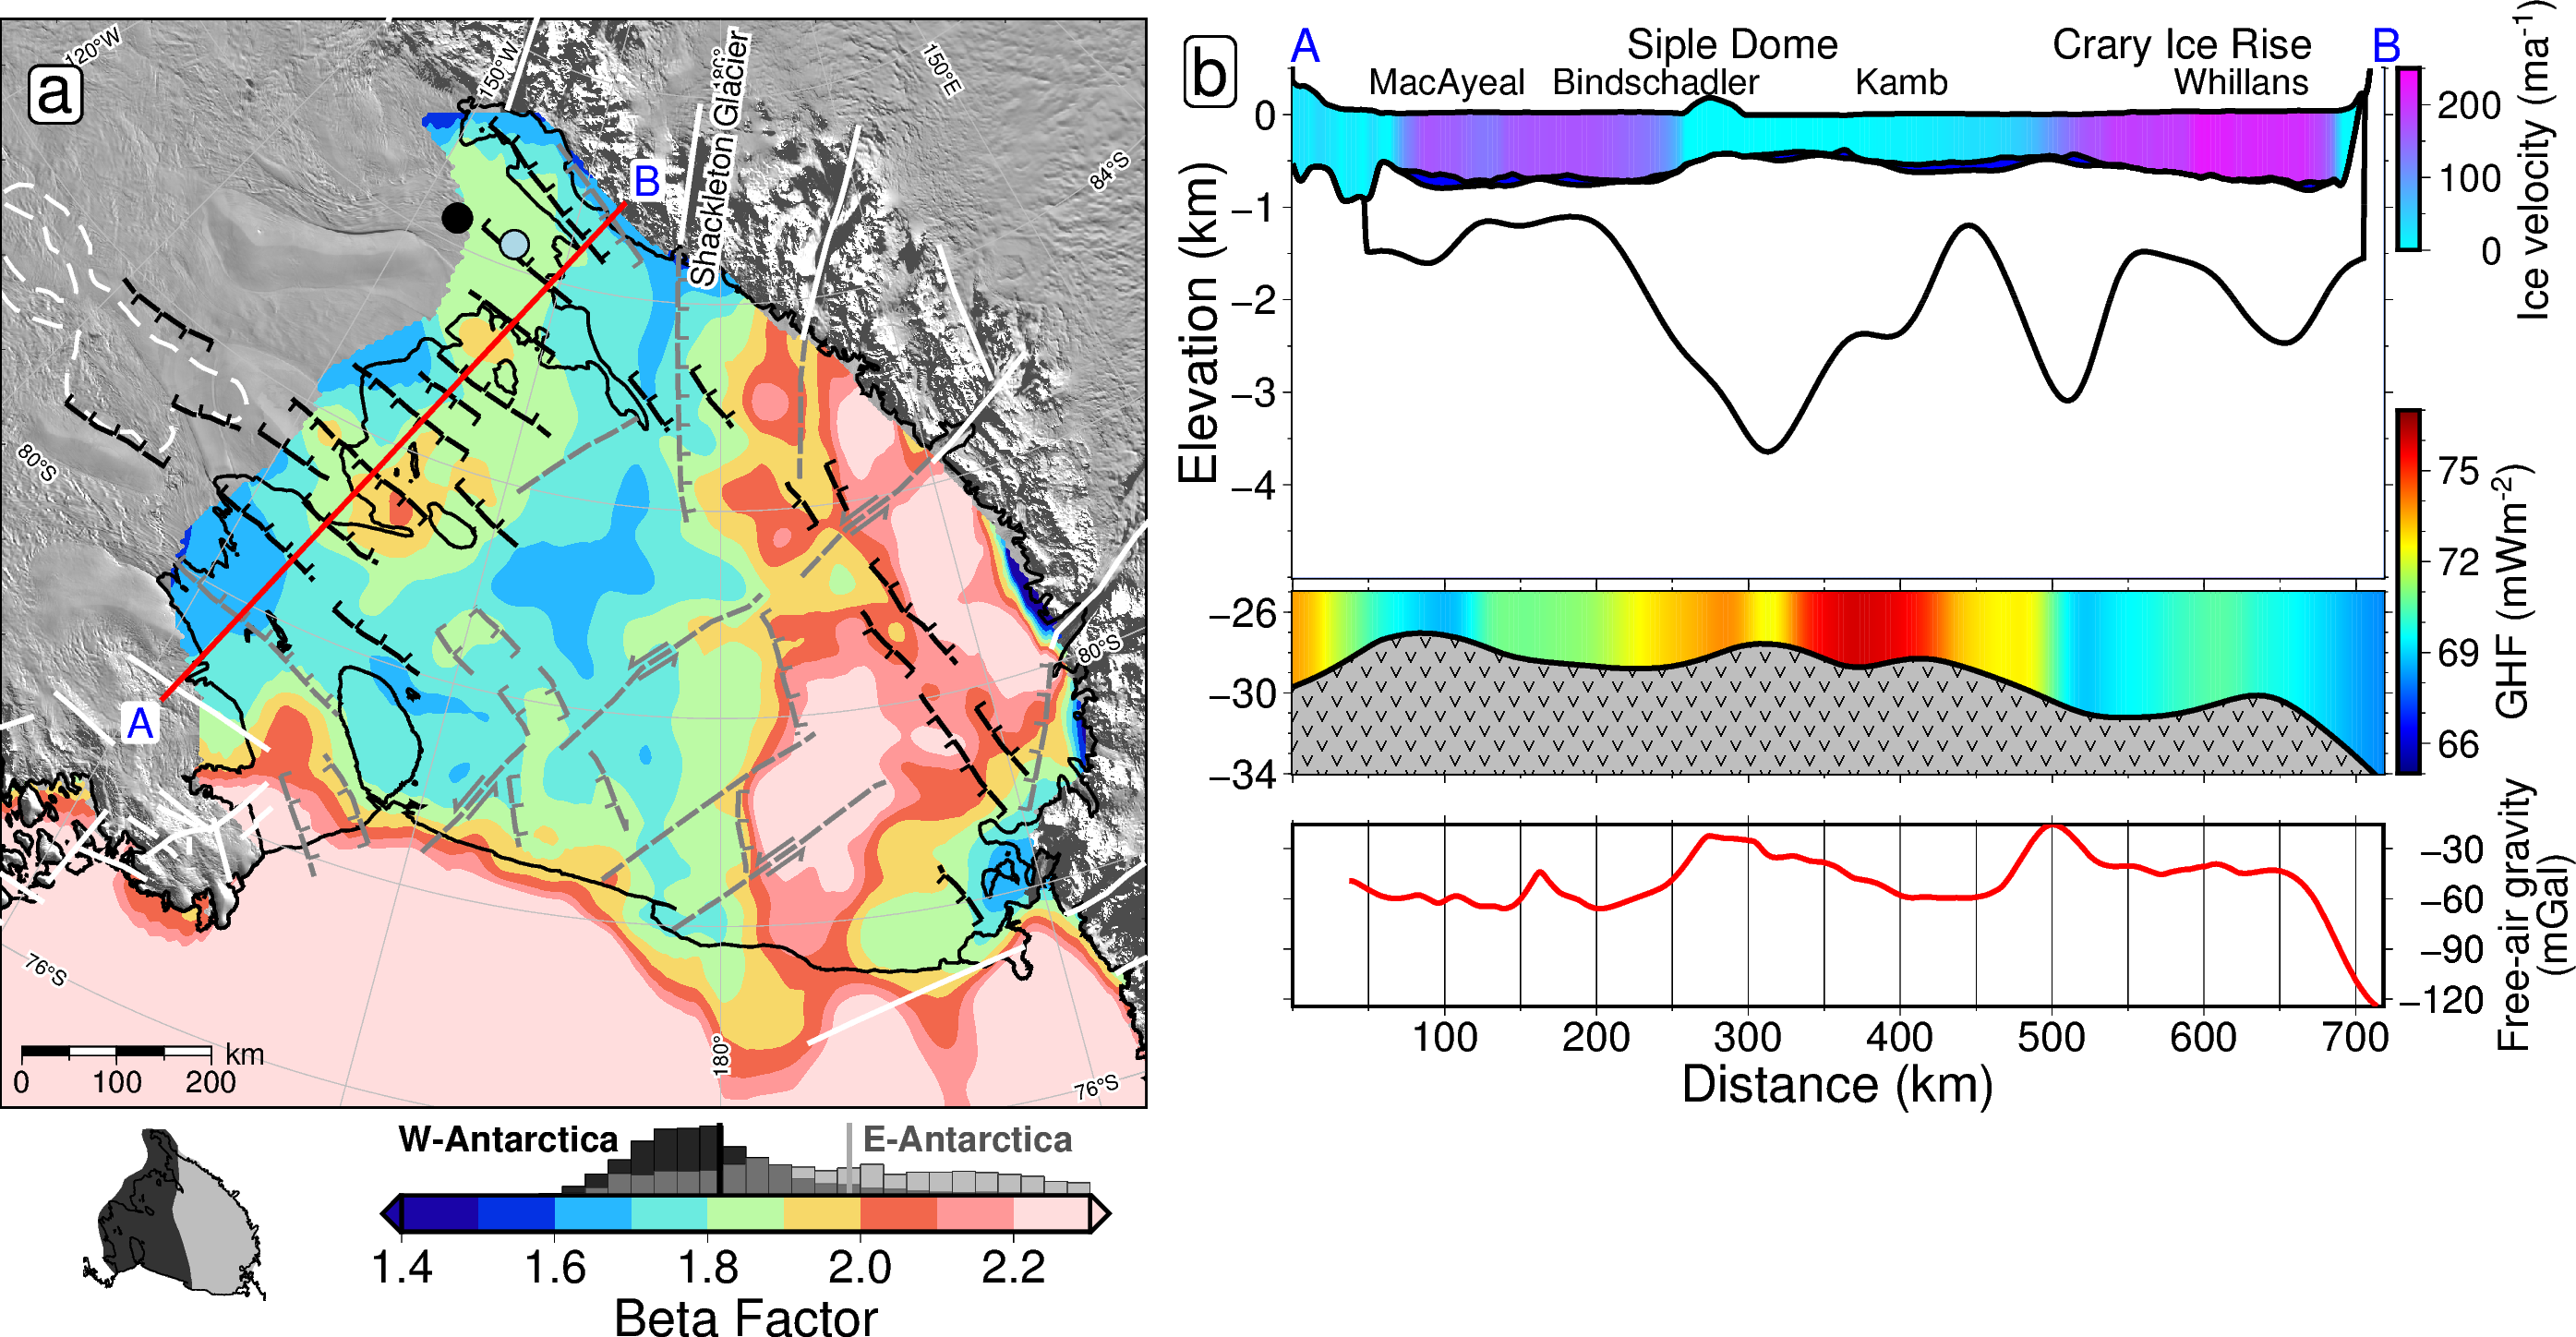

In [7]:
fig = pygmt.Figure()

# plot imagery as the basemap
with pygmt.config(MAP_FRAME_TYPE = 'inside'):
    fig.grdimage(region = fig_reg, projection = fig_proj, frame=["nwse", "xf100000", "yf100000", "g0"],  
                 grid ='../data/input/moa750_2009_hp1_v1.1.tif', 
                 cmap = '../data/plotting/moa.cpt', transparency=30)
    
# plot Beta Factors
fig.grdimage(region=fig_reg, projection=fig_proj, transparency=0, 
             grid ='../data/main_results/Ross_Embayment_beta.nc', 
             cmap = '../data/plotting/beta.cpt', dpi=1000, nan_transparent=True)

# plot groundingline and coastlines
fig.plot(data=gpd.read_file('../data/shapefiles/GroundingLine_Antarctica_v02.shp'), 
         pen = '1.2p,black', verbose='e')
fig.plot(data=gpd.read_file('../data/shapefiles/Coastline_Antarctica_v02.shp'), 
         pen='1.2p,black', verbose='e')

# Plot Bell et al. 2006 Basins
fig.plot(data = gpd.read_file('../data/shapefiles/bell_2006_outline.shp'), pen = 'thicker,white,-')

# plot graticules overtop, at 4d latitude and 30d longitude
with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                  MAP_ANNOT_OBLIQUE = 0, FONT_ANNOT_PRIMARY = '8p,black,-=2p,white', 
                  MAP_GRID_PEN_PRIMARY = 'grey', MAP_TICK_LENGTH_PRIMARY = '-10p',
                  MAP_TICK_PEN_PRIMARY = 'thinnest,grey', FORMAT_GEO_MAP = 'dddF',
                  MAP_POLAR_CAP = '90/90', ):
    fig.basemap(projection = fig_proj_ll, region = fig_reg,
                frame = ["NSWE", "xa30g15", "ya4g2"], verbose='e')
    with pygmt.config(FONT_ANNOT_PRIMARY = '8p,black'):
        fig.basemap(projection = fig_proj_ll, region = fig_reg,
                frame = ["NSWE", "xa30", "ya4"], verbose='e')

active_color='black'
inactive_color='gray50'
pen_fault=f'1.8p,{inactive_color},10_2'#10:2 dash:gap
hatch_style='f+.4c/.3c+l+i'
# Plot christines inactive faults, with hatches
fig.plot(projection = fig_proj, data =gpd.read_file('../data/shapefiles/RIS_inactive_faults_normal.shp'), pen=pen_fault)
fig.plot(data =gpd.read_file('../data/shapefiles/RIS_inactive_faults_normal.shp'), pen=f'1.2p,{inactive_color},10_2', style=hatch_style) #f for front, +.6c/0.3c for a tick every .6c, .3c long, +l for left side.
# Left lateral, with arrows
fig.plot(data =gpd.read_file('../data/shapefiles/RIS_inactive_faults_left_lateral.shp'), pen=pen_fault)
fig.plot(data =gpd.read_file('../data/shapefiles/RIS_inactive_faults_left_lateral.shp'), pen=f'1.5p,{inactive_color}', style='f-1c/.6c+l+s45+i') #f for front, -1 for 1 arrow, .8c for size of arrow, +l for left side, +s45 for arrow angle, +i for invisible line
# no kinematics
fig.plot(data =gpd.read_file('../data/shapefiles/RIS_inactive_faults.shp'), pen=pen_fault)
# Plot christines active faults, with hatches
fig.plot(data =gpd.read_file('../data/shapefiles/RIS_active_faults.shp'), pen=f'1.8p,{active_color},10_2')
fig.plot(data =gpd.read_file('../data/shapefiles/RIS_active_faults.shp'), pen=f'1.2p,{active_color},10_2', style=hatch_style) # f for front, +.3c/.3c for tick every .3c, .3c long, , +l for left side, +i for invisible

# Plot Goodge 2020 Faults, TAM
pen = '2p,white'
fig.plot(projection = fig_proj, data =gpd.read_file('../data/shapefiles/goodge_faults.shp'), pen=pen)
# Plot Siddoway et al. 2008 Faults, EVII
fig.plot(data =gpd.read_file('../data/shapefiles/siddoway_2008_EVII_faults.shp'), pen=pen) 
# Plot Ferraccioli et al. 2002 Faults, EVII
fig.plot(data =gpd.read_file('../data/shapefiles/ferraccioli_2002_faults.shp'), pen=pen)
# Plot Chiappini Ross Fault (Behrendt 1996)
fig.plot(data =gpd.read_file('../data/shapefiles/chiappini_2002_Ross_Fault.shp'), pen=pen)

# plot GHF point measurements; Subglacial Lake Whillans and Whillans Basin
fig.plot(x=-277613, y=-561461,
         pen = '.8p,black',
         color = 'black',
         style = 'c0.4c', verbose='e')
#plot Whillans Basin Points
fig.plot(x=-217457, y=-589312,
         pen = '.8p,black',
         color = 'lightblue',
         style = 'c0.4c', verbose='e')

# for beta factor colorar with histogram and inset map
barwidth = fig_width/10 * 0.6 # color bar width is 40% of the map width, in cm
bar_offset= (fig_width/10 - (barwidth)/2)/2
pos_str = f'jBL+w{barwidth}c/.5c+jTL+o{bar_offset}c/1.2c+h+ebf' 
hist_reg = f'{beta_cpt_limits}/0/14',   # this needs to match CMAP limits, 0/14 of 0-14% for histogram

WANT_beta=pygmt.grd2xyz(grid='..\data/tmp\Ross_Embayment_beta_RIS_WANT_mask.nc')
EANT_beta=pygmt.grd2xyz(grid='..\data/tmp\Ross_Embayment_beta_RIS_EANT_mask.nc')

fig.shift_origin(xshift=f'{bar_offset}c', yshift="-1.2c",)

fig.histogram( data=EANT_beta.z,
                region=hist_reg,
                fill='grey',
                projection=f"X{barwidth}c/1c",
                frame=False,
                series=.03,#width of bin in data units
                pen=".1p",
                histtype=1,
                transparency=0) 
fig.histogram( data=WANT_beta.z,
                fill='gray14',
                frame=False,
                series=.03,
                pen=".1p",
                histtype=1,
                transparency=0) 
fig.histogram( data=EANT_beta.z,
                fill='grey',
                frame=False,
                series=.03,
                pen=".1p",
                histtype=1,
                transparency=50) 

fig.plot(x=[WANT_beta.z.mean(),WANT_beta.z.mean()], y=[0,14], pen='2p,black')
fig.plot(x=[EANT_beta.z.mean(),EANT_beta.z.mean()], y=[0,14], pen='2p,darkgray')

fig.text(x=1.54,y=11, text = "W-Antarctica",
        font = '14p,Helvetica-Bold,black', no_clip=True)
fig.text(x=2.14,y=11, text = "E-Antarctica",
        font = '14p,Helvetica-Bold,gray32') 

fig.shift_origin(xshift=f'-{bar_offset}c', yshift="1.2c",)

with pygmt.config(FONT_ANNOT_PRIMARY = '18p,black', FONT_LABEL = '20p,black'):
    fig.colorbar(cmap='../data/plotting/beta.cpt', position = pos_str, frame=['x.2+l"Beta Factor"'], verbose='e')

# INSET MAP
shelfwidth = 2.5 # width of inset in cm
shelfreg = '-690000/431000/-1390000/-374000'
shelfmap = f'X{shelfwidth}c'
with fig.inset(position=f'JTL+jCM+w{shelfwidth}c+o2.4c/-2.4c'):
    fig.plot(projection = shelfmap, region = shelfreg, data = gpd.read_file('../data/shapefiles/RIS_East.shp'), color = "gray", transparency = 0)
    fig.plot(data = gpd.read_file('../data/shapefiles/RIS_West.shp'), color = "gray20", transparency = 0)
    fig.plot(data = gpd.read_file('../data/shapefiles/Groundingline_Antarctica_v02.shp'), pen='0.5p,black')
    fig.plot(data = gpd.read_file('../data/shapefiles/Coastline_Antarctica_v02.shp'), pen='0.5p,black')
    
# Scalebar
with pygmt.config(FONT_ANNOT_PRIMARY = '12p,black', FONT_LABEL = '12p,black', MAP_SCALE_HEIGHT='7p', MAP_TICK_PEN_PRIMARY = '0.5p,black'):
    fig.basemap(region = fig_reg, projection = fig_proj_ll, map_scale='jBL+w200k+c170E/71S+f+l"km"+ar+o0.3c/0.6c', verbose='e') 

# plot A for profile
fig.text(projection = fig_proj, region = fig_reg,
        x = earth_profiles.x.iloc[0],
        y = earth_profiles.y.iloc[0], 
        text = "A", fill = 'white', font = '16p,Helvetica,blue', offset = 'j.1/.1',
        justify="TR", clearance = '+tO')

# plot B for profile
fig.text(x = earth_profiles.x.iloc[-1],
         y = earth_profiles.y.iloc[-1], 
         text = "B", fill = 'white', font = '16p,Helvetica,blue',  offset = 'j.1/.1',
         justify='BL', clearance = '+tO')

# plot a for left figure panel
fig.text(position='TL', text = "a",  offset = 'j.5/.8', pen = '1p,black',
         fill = 'white', font = '26p,Helvetica,black', clearance = '+tO')

# add location label
fig.text(x=10000, y=-500000, angle=82, justify='BC', text='Shackleton Glacier', font='12,Helvetica,black,-=3p,white')
fig.text(x=10000, y=-500000, angle=82, justify='BC', text='Shackleton Glacier', font='12,Helvetica,black')

#plot profile line locatoin
fig.plot(projection=fig_proj, region=fig_reg, x=earth_profiles.x, y=earth_profiles.y, pen='2p,red')






#################
#################
# shift origin to right, and start plot panel b
#################
#################  

fig.shift_origin(xshift=(fig_width/10)+.8, yshift=-.6)









region_lower=[earth_profiles.Distance.min(), earth_profiles.Distance.max(),
        -34000,
        -25000]
region_upper=[earth_profiles.Distance.min(), earth_profiles.Distance.max(),
        -5000,
         500]
region_data=[data_profiles.Distance.min(), data_profiles.Distance.max(),
        data_profiles[data_profilelist[0]].min(),
        data_profiles[data_profilelist[0]].max()]

fig.shift_origin(xshift=1.2, yshift=2)
################
################
# Gravity Profile
with open("../data/plotting/xannots.txt", "w") as fp:
    fp.write('''
    100000 a 100
    200000 a 200
    300000 a 300
    400000 a 400
    500000 a 500
    600000 a 600
    700000 a 700''')
with pygmt.config(FONT_ANNOT= '16p,black', FONT_LABEL='20p'):    
    fig.basemap(region=region_data, projection="X15c/2.5c", frame=["Sn", 'xc../data/plotting/xannots.txt+l"Distance (km)"', 'xa50000g50000']) #xa100g50f50 gives x axis with labels every 100, ticks and gridlines every 50
with pygmt.config(FONT_ANNOT= '15p,black', FONT_LABEL='16p'):    
    fig.basemap(region=region_data, projection="X15c/2.5c", frame=["wE", 'ya30+l"Free-air gravity"']) #xa100g50f50 gives x axis with labels every 100, ticks and gridlines every 50
with pygmt.config(FONT_ANNOT= '15p,black', FONT_LABEL='16p', MAP_LABEL_OFFSET='20p'):
    fig.basemap(frame=["E", 'ya30+l"(mGal)"'])
fig.plot(x=data_profiles.Distance, y=data_profiles[data_profilelist[0]], pen='2p,red')
################
################
# Lower Panel
fig.shift_origin(yshift="h+.7c")
with open("../data/plotting/yannots_lower.txt", "w") as fp:
    fp.write('''
    -26000 a -26
    -30000 a -30
    -34000 a -34''')
with pygmt.config(FONT_ANNOT= '16p,black', FONT_LABEL='18p'):     
    fig.basemap(region=region_lower, projection="X15c/2.5c", frame=["Wnse", 'yc../data/plotting/yannots_lower.txt', 'ya1000', 'xf50000a100000']) 
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[4]],
        close='+yb', color='p28+r200+bgrey')

fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[4]], 
         style='b1000u+b-25000',
         cmap='../data/plotting/GHF.cpt', color=earth_profiles[GHF])

with pygmt.config(FONT_ANNOT= '15p,black', FONT_LABEL='16p'): 
    fig.colorbar(cmap = '../data/plotting/GHF.cpt', 
             position='JBR+jBL+w5c/0.3+v+o.2c/0c',
             frame=["a3f1",'x+l"GHF (mWm@+-2@+)"'])

# lines
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[4]], pen='2p,black')
################
################
# Upper Panel
fig.shift_origin(yshift="h+.2c")
with open("../data/plotting/yannots_upper.txt", "w") as fp:
    fp.write('''
    -4000 a -4
    -3000 a -3
    -2000 a -2
    -1000 a -1 
    0 a 0''')
with pygmt.config(FONT_ANNOT= '16p,black', FONT_LABEL='20p'): 
    fig.basemap(region=region_upper, projection="X15c/7c", frame=["Wse", 'xf50000a100000','yc../data/plotting/yannots_upper.txt+l"Elevation (km)"','ya500']) 
################
################
# ice 
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[0]],
        style='b1000u', cmap='../data/plotting/vel.cpt', color=earth_profiles[ice_vel])
# water
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[1]],
        close='+yb', color='blue')
# sediment
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[2]],
        close='+yb', color='white')
# lines
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[0]], pen='2p,black')
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[1]], pen='2p,black')
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[2]], pen='2p,black')
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[3]], pen='2p,black')
fig.text(x=-2000,  y=750, text='A', font='18p,Helvetica,blue', justify='LM', no_clip=True)
fig.text(x=710000, y=750, text='B', font='18p,Helvetica,blue', justify='LM', no_clip=True)

# Labels
fig.text(x=50000, y=220, text='MacAyeal', font='14p,Helvetica,black', justify='LB')
fig.text(x=171000, y=220, text='Bindschadler', font='14p,Helvetica,black', justify='LB')
fig.text(x=370000, y=220, text='Kamb', font='14p,Helvetica,black', justify='LB')
fig.text(x=580000, y=220, text='Whillans', font='14p,Helvetica,black', justify='LB')

fig.text(x=220000, y=780, text='Siple Dome', font='16p,Helvetica,black', justify='LM', no_clip=True)
fig.text(x=500000, y=780, text='Crary Ice Rise', font='16p,Helvetica,black', justify='LM', no_clip=True)

with pygmt.config(FONT_ANNOT= '15p,black', FONT_LABEL='16p'): 
    fig.colorbar(cmap="../data/plotting/vel.cpt",
            position="JTR+jTL+w2.5c/0.3c+v+o.2c/0c",
            frame=["a100f50",'x+l"Ice velocity (ma@+-1@+)"'])

fig.shift_origin(yshift=.5, xshift=-1.5)
fig.text(region=region_upper, 
         projection="X15c/7c",
            position='TL',
            text = "b",
            fill = 'white',
            pen = '1p,black',
            font = '26p,Helvetica,black',
            offset = 'j0.1/.2',
            clearance = '+tO')

fig.show(dpi=200)

## Save figure

In [10]:
out='outputs/Fig4_beta_factors_template.png'
fig.savefig(out, dpi=1000) 
# export as png, import into Corel Draw file:X_section/template_sed_layers.crd , move to back, drag into place, export as png

In [21]:
print('EANT beta mean:\n',EANT_beta.z.mean(),'\n')
print('WANT beta mean:\n',WANT_beta.z.mean(),'\n')

EANT beta mean:
 1.9856535613730089 

WANT beta mean:
 1.8162590791705502 

